In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Clustering

The main idea behind clustering is pretty straightforward. Basically, we say to ourselves, "I have these points here, and I can see that they organize into groups. It would be nice to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>*The examples of the outcomes from different algorithms from scikit-learn*</figcaption></figure>

The algorithms listed below do not cover all the clustering methods out there, but they are the most commonly used ones.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

In [2]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [3]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

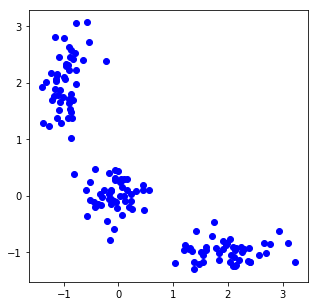

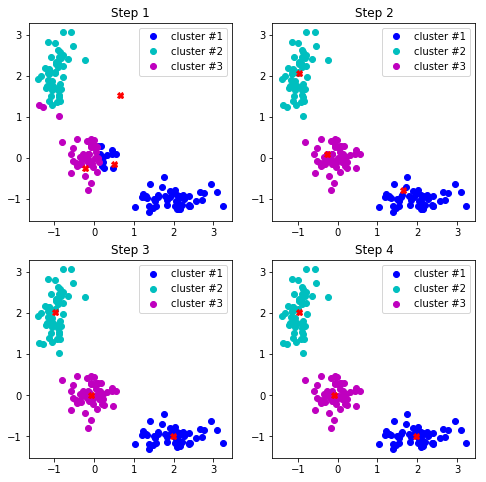

In [4]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));
plt.show()

Here, we used Euclidean distance, but the algorithm will converge with any other metric. You can not only vary the number of steps or the convergence criteria but also the distance measure between the points and cluster centroids.

Another "feature" of this algorithm is its sensitivity to the initial positions of the cluster centroids. You can run the algorithm several times and then average all the centroid results.

## Choosing the number of clusters for K-means

In contrast to the supervised learning tasks such as classification and regression, clustering requires more effort to choose the optimization criterion. Usually, when working with k-means, we optimize the sum of squared distances between the observations and their centroids.

$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

where $C$ – is a set of clusters with power $K$, $\mu_k$ is a centroid of a cluster $C_k$.

This definition seems reasonable -- we want our observations to be as close to their centroids as possible. But, there is a problem -- the optimum is reached when the number of centroids is equal to the number of observations, so you would end up with every single observation as its own separate cluster.

In order to avoid that case, we should choose a number of clusters after which a function $J(C_k)$ is decreasing less rapidly. More formally,
$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Let's look at an example.

In [5]:
from sklearn.cluster import KMeans

In [6]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


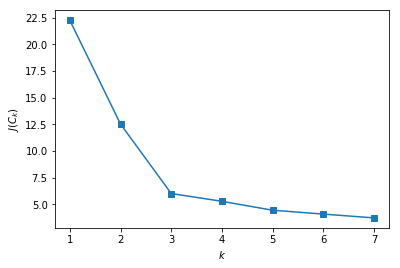

In [7]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.show()

We see that $J(C_k)$ decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3. 

## Affinity Propagation

Affinity Propagation creates clusters by sending messages between pairs of samples until convergence. **A dataset is then described using a small number of exemplars**, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

## The algorithm

Let $x_1$ through $x_n$ be a set of data points, with no assumptions made about their internal structure, and let $s$ be a function that quantifies the similarity between any two points, such that $s(x_i, x_j) > s(x_i, x_k) \text{ iff } x_i$ is more similar to $x_j$ than to $x_k$. For this example, the negative squared distance of two data points was used i.e. for points xi and xk, 
${\displaystyle s(i,k)=-\left\|x_{i}-x_{k}\right\|^{2}}$

The diagonal of s i.e. ${s(i,i)}$ is particularly important, as it represents the input preference, meaning how likely a particular input is to become an exemplar. When it is set to the same value for all inputs, it controls how many classes the algorithm produces. A value close to the minimum possible similarity produces fewer classes, while a value close to or larger than the maximum possible similarity, produces many classes. It is typically initialized to the median similarity of all pairs of inputs.

The algorithm proceeds by alternating two message passing steps, to update two matrices:

* The "responsibility" matrix *$R$* has values $r(i, k)$ that quantify how well-suited $x_k$ is to serve as the exemplar for $x_i$, relative to other candidate exemplars for $x_i$.

* The "availability" matrix *$A$* contains values $a(i, k)$ that represent how "appropriate" it would be for $x_i$ to pick $x_k$ as its exemplar, taking into account other points' preference for $x_k$ as an exemplar.

Both matrices are initialized to all zeroes, and can be viewed as log-probability tables. The algorithm then performs the following updates iteratively:

First, responsibility updates are sent around: 
$$ {\displaystyle r(i,k)\leftarrow s(i,k)-\max _{k'\neq k}\left\{a(i,k')+s(i,k')\right\}} $$
Then, availability is updated per

$$ {\displaystyle a(i,k)\leftarrow \min \left(0;r(k,k)+\sum _{i'\not \in \{i,k\}}\max(0,r(i',k))\right)} $$ 
for ${\displaystyle i\neq k}$ and
$$ {\displaystyle a(k,k)\leftarrow \sum _{i'\neq k}\max(0,r(i',k))} $$

The iterations are performed until either the cluster boundaries remain unchanged over a number of iterations, or after some predetermined number of iterations. The exemplars are extracted from the final matrices as those whose 'responsibility + availability' for themselves is positive i.e.

$${\displaystyle (r(i,i)+a(i,i))>0}
$$

## Pros and cons

Affinity Propagation can be interesting as **it automatically chooses the number of clusters based on the data provided**. For this purpose, the two important parameters are the preference, which controls how many exemplars are used, and the damping factor which damps the responsibility and availability messages to avoid numerical oscillations when updating these messages.

**The main drawback of Affinity Propagation is its complexity**. The algorithm has a time complexity of the order $O(N^2 T)$, where $N$ is the number of samples and $T$ is the number of iterations until convergence. Further, the memory complexity is of the order $O(N^2)$ if a dense similarity matrix is used, but reducible if a sparse similarity matrix is used. This makes Affinity Propagation most appropriate for small to medium sized datasets.

## Agglomerative clustering


The following algorithm is the simplest and easiest to understand among all the the clustering algorithms without a fixed number of clusters.


The algorithm is fairly simple:
1. We start by assigning each observation to its own cluster
2. Then sort the pairwise distances between the centers of clusters in descending order
3. Take the nearest two neigbor clusters and merge them together, and recompute the centers
4. Repeat steps 2 and 3 until all the data is merged into one cluster

The process of searching for the nearest cluster can be conducted with different methods of bounding the observations:
1. Single linkage 
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage 
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage 
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage 
$d(C_i, C_j) = ||\mu_i - \mu_j||$

The 3rd one is the most effective in computation time since it does not require recomputing the distances every time the clusters are merged.

The results can be visualized as a beautiful cluster tree (dendogram) to help recognize the moment the algorithm should be stopped to get optimal results. There are plenty of Python tools to build these dendograms for agglomerative clustering.

Let's consider an example with the clusters we got from K-means:

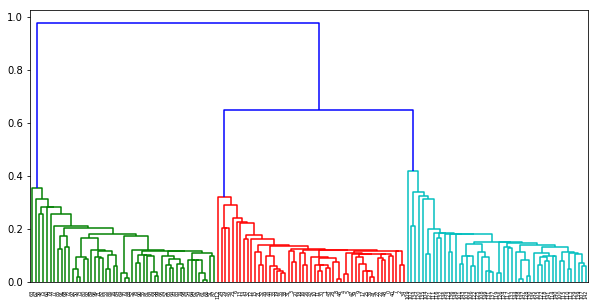

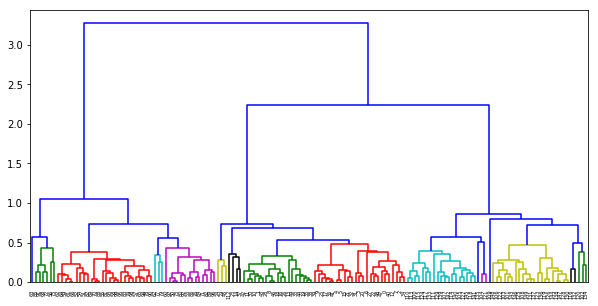

In [10]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X) 
# linkage — is an implementation of agglomerative algorithm
Z = hierarchy.linkage(distance_mat, 'single')
Z1 = hierarchy.linkage(distance_mat, 'average')
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)
plt.figure(figsize=(10, 5))
d1 = hierarchy.dendrogram(Z1, color_threshold=0.5)
plt.show()

## DBSCAN

DBSCAN stands for  **d**ensity-**b**ased **s**patial **c**lustering of **a**pplications with **n**oise. It is able to find arbitrary shaped clusters and clusters with noise (i.e. outliers).

The main idea behind DBSCAN is that a point belongs to a cluster if it is close to many points from that cluster.

There are two key parameters of DBSCAN:
* **eps:** The distance that specifies the neighborhoods. Two points are considered to be neighbors if the distance between them are less than or equal to eps.
* **minPts:** Minimum number of data points to define a cluster.

Based on these two parameters, points are classified as core point, border point, or outlier:
* **Core point:** A point is a core point if there are at least minPts number of points (including the point itself) in its surrounding area with radius eps.
* **Border point:** A point is a border point if it is reachable from a core point and there are less than minPts number of points within its surrounding area.
* **Outlier:** A point is an outlier if it is not a core point and not reachable from any core points.
![alt text](https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg)

In this case, minPts is 4. Red points are core points because there are at least 4 points within their surrounding area with radius eps. This area is shown with the circles in the figure. The yellow points are border points because they are reachable from a core point and have less than 4 points within their neighborhood. Reachable means being in the surrounding area of a core point. The points B and C have two points (including the point itself) within their neigborhood (i.e. the surrounding area with a radius of eps). Finally N is an outlier because it is not a core point and cannot be reached from a core point.

Some definitions that the algorithm will use:
* **Directly Density Reachable:** Data-point $\bf a$ is directly density reachable from a point $\bf b$ if $\bf b$ is a core point, and $\bf a$ is in **eps** neighborhood of $\bf b$.
* **Density Reachable:** Point $\bf a$ is density reachable from a point $\bf b$, if there exists a chain of points $c_1,c_2,...,c_n$, where $c_1=b$ and $c_n=a$, such that $c_{i+1}$ is directly density reachable from $c_i$. 
* **Density Connected:** There can be cases when 2 border points will belong to the same cluster but they don’t share a specific core point, then we say that they are density connected if, there exists a common core point, from which these borders points are density reachable. As you can understand that density connectivity is symmetric.
![alt text](https://miro.medium.com/max/700/1*bQbRDcoW1Jf10HcrBUdyWA.png)

The steps of the algorithm:
1. The algorithm starts with an arbitrary point which has not been visited and its neighborhood information is retrieved from the **eps** parameter.
2. If this point contains **minPts** within **eps** neighborhood, cluster formation starts. Otherwise the point is labeled as noise. This point can be later found within the **eps** neighborhood of a different point and, thus can be made a part of the cluster. Concept of density reachable and density connected points are important here.
3. If a point is found to be a core point then the points within the **eps** neighborhood is also part of the cluster. So all the points found within **eps** neighborhood are added, along with their own **eps** neighborhood, if they are also core points.
4. The above process continues until the density-connected cluster is completely found.
5. The process restarts with a new point which can be a part of a new cluster or labeled as noise.

Choosing **eps** and **minPts**:
* **minPts** is recommended to be minPts $\geq D+1$, where $D$ is the number of features in our dataset. A widely used choice of minPts is minPts$=2 * D$ 
* **eps** is dependent on the distance metric that will be used. When we already chose minPts and the distance metric, eps can be chosen using kd tree and elbow method.

In [35]:
from sklearn import datasets
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

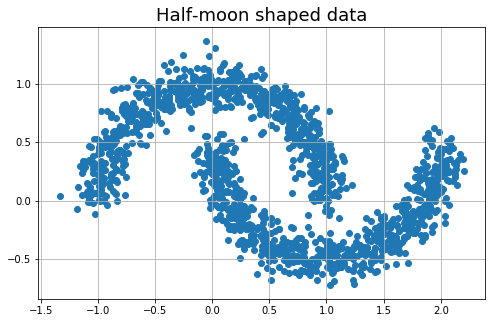

In [40]:
n_samples = 1500
noisy_moons,moon_labels = datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons=np.array(noisy_moons)
plt.figure(figsize=(8,5))
plt.title("Half-moon shaped data", fontsize=18)
plt.grid(True)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1])
plt.show()


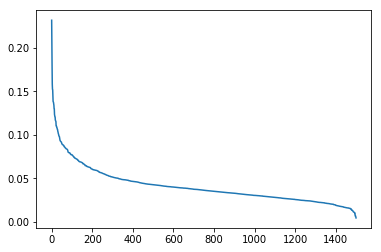

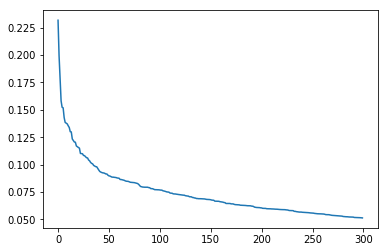

In [49]:
minPts = 2 * 2
tree = KDTree(noisy_moons)
dist, ind = tree.query(noisy_moons, k=minPts)
plt.plot(np.arange(noisy_moons.shape[0]), -1 * np.sort(-1*dist.max(axis=1)))
plt.show()
plt.plot(np.arange(noisy_moons.shape[0])[:300], -1 * np.sort(-1*dist.max(axis=1))[:300])
plt.show()

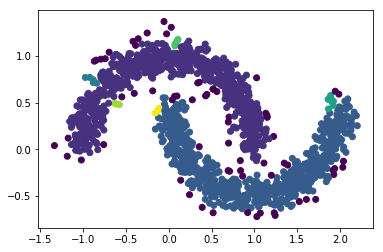

In [50]:
model = DBSCAN(eps=0.07, min_samples=minPts)
labels = model.fit_predict(noisy_moons)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=labels)
plt.show()

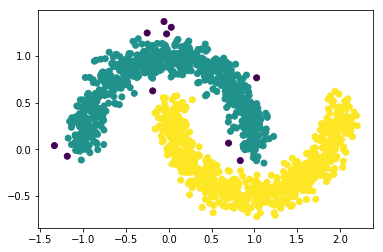

In [51]:
model = DBSCAN(eps=0.11, min_samples=minPts)
labels = model.fit_predict(noisy_moons)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=labels)
plt.show()

## Goodness of fit



**Silhouette**

Silhouette score lets us estimate the quality of the clustering using only the initial, unlabeled sample and the clustering result. To start with, for each observation, the silhouette coefficient is computed. Let $a$ be the mean of the distance between an object and other objects within one cluster and $b$ be the mean distance from an object to objects from the nearest cluster (different from the one the object belongs to). Then the silhouette measure for this object is $$s = \frac{b - a}{\max(a, b)}.$$

The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the $[-1, 1]$ range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

With the help of silhouette, we can identify the optimal number of clusters $k$ (if we don't know it already from the data) by taking the number of clusters that maximizes the silhouette coefficient.